In [ ]:
!gdown --id 1-t-2vBTicFOkf72wb97k1gp-rd0ybPIB
!mkdir assignment2
!unzip Assignment2_data.zip -d assignment2

In [3]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from nms import nms
import os
import cv2 
import math

from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Train a convolutional neural network for binary classification


In [69]:
# Create Dataset and DataLoader for training data
transforms = Compose([Resize((48, 48)), ToTensor(), Normalize(mean=(0.5,0.5,0.5,), std=(0.5,0.5,0.5,))])

batch_size = 64
train_root_dir = './assignment2/train'
train_dataset = ImageFolder(train_root_dir, transform=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print("The traning dataset size is {}".format(len(train_dataset)))

The traning dataset size is 89340


In [70]:
# Create Dataset and DataLoader for validation data
valid_root_dir = './assignment2/val'
valid_dataset = ImageFolder(valid_root_dir, transform=transforms)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print("the validation dataset size is {}".format(len(valid_dataset)))

the validation dataset size is 10000


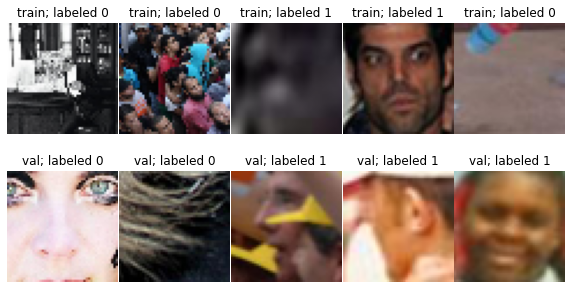

In [71]:
# Visualize a few images from both class
fig, axes = plt.subplots(2, 5, figsize=(10,5))
axes = [ax for axs in axes for ax in axs]

for j in range(5):
    idx = np.random.randint(0, len(train_dataset))
    axes[j].imshow(train_dataset[idx][0].permute(1,2,0)*0.5+0.5)
    axes[j].axis('off')
    axes[j].set_title('train; labeled {}'.format(train_dataset[idx][1]))


    idx = np.random.randint(0, len(valid_dataset))
    axes[j+5].imshow(valid_dataset[idx][0].permute(1,2,0)*0.5+0.5)
    axes[j+5].axis('off')
    axes[j+5].set_title('val; labeled {}'.format(valid_dataset[idx][1]))
plt.subplots_adjust(wspace=0.01)

In [72]:
# Implement a binary convolutional model
class BinaryConvModel(nn.Module):
    def __init__(self):
        super(BinaryConvModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(in_channels=256, out_channels=2, kernel_size=1, stride=1)
        )

    def forward(self, input):
        output = self.conv_layers(input)
        return output

model_binaryConv = BinaryConvModel().to(device)

In [73]:
# Check the output size
input_ = torch.randn(4,3,48,48).to(device)
with torch.no_grad():
    output = model_binaryConv(input_)
output.shape

torch.Size([4, 2, 1, 1])

In [74]:
# Extra step - see the output for different input sizes
for side in range(48, 100, 1):
    input_ = torch.randn(4, 3, side, side).to(device)
    with torch.no_grad():
        output = model_binaryConv(input_)
    print('Input shape: ', input_.shape, '; output shape ', output.shape)

Input shape:  torch.Size([4, 3, 48, 48]) ; output shape  torch.Size([4, 2, 1, 1])
Input shape:  torch.Size([4, 3, 49, 49]) ; output shape  torch.Size([4, 2, 1, 1])
Input shape:  torch.Size([4, 3, 50, 50]) ; output shape  torch.Size([4, 2, 1, 1])
Input shape:  torch.Size([4, 3, 51, 51]) ; output shape  torch.Size([4, 2, 1, 1])
Input shape:  torch.Size([4, 3, 52, 52]) ; output shape  torch.Size([4, 2, 1, 1])
Input shape:  torch.Size([4, 3, 53, 53]) ; output shape  torch.Size([4, 2, 1, 1])
Input shape:  torch.Size([4, 3, 54, 54]) ; output shape  torch.Size([4, 2, 1, 1])
Input shape:  torch.Size([4, 3, 55, 55]) ; output shape  torch.Size([4, 2, 1, 1])
Input shape:  torch.Size([4, 3, 56, 56]) ; output shape  torch.Size([4, 2, 2, 2])
Input shape:  torch.Size([4, 3, 57, 57]) ; output shape  torch.Size([4, 2, 2, 2])
Input shape:  torch.Size([4, 3, 58, 58]) ; output shape  torch.Size([4, 2, 2, 2])
Input shape:  torch.Size([4, 3, 59, 59]) ; output shape  torch.Size([4, 2, 2, 2])
Input shape:  to

In [75]:
# Write the training code
def train(model, train_dataloader, optimizer, loss_fn):
    losses = []
    predictions = 0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        output = model(images).squeeze(3).squeeze(2) # flatten 
        optimizer.zero_grad()
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        predicted = output.argmax(1)
        predictions += (predicted==labels).sum().item() # better than averaging mini-batch accuracies
    train_loss = sum(losses)/len(losses)
    train_accuracy = 100 * predictions / len(train_dataloader.dataset)
    return train_loss, train_accuracy

def evaluate(model, dataloader, loss_fn):
    losses = []
    predictions = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            output = output.view(output.size(0), output.size(1))
            loss = loss_fn(output, labels)

            losses.append(loss.item())
            predicted = output.argmax(1)
            predictions += (predicted==labels).sum().item()
    valid_loss = sum(losses)/len(losses)
    valid_accuracy = 100 * predictions / len(dataloader.dataset)
    return valid_loss, valid_accuracy

def fit(train_dataloader, valid_dataloader, model, optimizer, loss_fn, n_epochs):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    for epoch in range(n_epochs):
        model.train()
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
        model.eval()
        valid_loss, valid_accuracy = evaluate(model, valid_dataloader, loss_fn)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)
        print('Epoch {:2}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, valid_loss: {:.4f}, valid_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                                             train_losses[-1], train_accuracies[-1],
                                                                                                                             valid_losses[-1], valid_accuracies[-1]))
    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [76]:
def plot(n_epochs, train_losses, train_accuracies, valid_losses, valid_accuracies):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    axes[0].plot(np.arange(n_epochs), train_losses)
    axes[0].plot(np.arange(n_epochs), valid_losses)
    axes[0].legend(['train loss', 'valid loss'])
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss Value')
    axes[0].set_title('Train & Valid Loss')

    axes[1].plot(np.arange(n_epochs), train_accuracies)
    axes[1].plot(np.arange(n_epochs), valid_accuracies)
    axes[1].legend(['train accuracy', 'valid accuracy'])
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Train & Valid Accuracy')
    plt.tight_layout()
    plt.show()

In [77]:
# Train the network 
model_binaryConv = BinaryConvModel().to(device)
 
learning_rate = 3e-4
optimizer = torch.optim.Adam(model_binaryConv.parameters(), lr=learning_rate)
n_epochs = 10
loss_fn = nn.CrossEntropyLoss()

train_losses, valid_losses, train_accuracies, valid_accuracies = fit(train_dataloader, valid_dataloader, model_binaryConv, optimizer, loss_fn, n_epochs)

Epoch  1/10: train_loss: 0.2405, train_accuracy: 90.1511, valid_loss: 0.1729, valid_accuracy: 93.4100
Epoch  2/10: train_loss: 0.1573, train_accuracy: 93.8986, valid_loss: 0.1501, valid_accuracy: 94.3700
Epoch  3/10: train_loss: 0.1380, train_accuracy: 94.7146, valid_loss: 0.1365, valid_accuracy: 94.9900
Epoch  4/10: train_loss: 0.1253, train_accuracy: 95.1925, valid_loss: 0.1253, valid_accuracy: 95.1900
Epoch  5/10: train_loss: 0.1137, train_accuracy: 95.6805, valid_loss: 0.1212, valid_accuracy: 95.5600
Epoch  6/10: train_loss: 0.1057, train_accuracy: 96.0063, valid_loss: 0.1194, valid_accuracy: 95.4200
Epoch  7/10: train_loss: 0.0966, train_accuracy: 96.3387, valid_loss: 0.1202, valid_accuracy: 95.8700
Epoch  8/10: train_loss: 0.0892, train_accuracy: 96.6532, valid_loss: 0.1384, valid_accuracy: 95.2000
Epoch  9/10: train_loss: 0.0819, train_accuracy: 96.8749, valid_loss: 0.1196, valid_accuracy: 95.6300
Epoch 10/10: train_loss: 0.0744, train_accuracy: 97.2263, valid_loss: 0.1237, vali

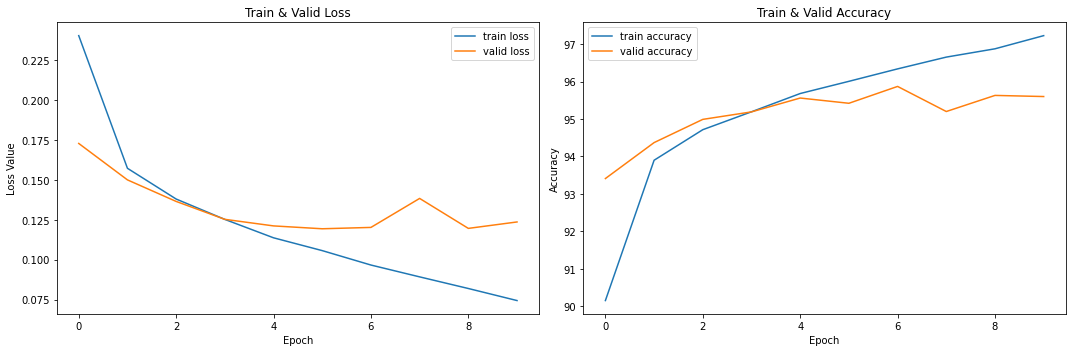

In [78]:
# Plot the results
plot(10, train_losses, train_accuracies, valid_losses, valid_accuracies)

# 2. Implement fully convolutional face detector that uses the binary classifier


In [79]:
class FullyConvolutionalDetector:
    def __init__(self, model, max_res=1024, scales=[1, 0.8, 0.6, 0.4, 0.2, 0.1], threshold=0.5):
        self.model = model
        self.max_res = max_res
        self.scales = scales
        self.threshold = threshold
    
    @torch.no_grad()
    def detect_single_scale(self, image):
        '''Run a fully convolutional model on the input image'''
        ## Preprocess the image (subtract and divide as in training)
        with torch.no_grad():
            output = self.model(torch.tensor(image).permute(2,0,1).unsqueeze(0).to(device)*2.-1.) # (x-0.5)/0.5 = 2x-1
        output = torch.softmax(output, dim=1)

        ## Get probabilities for the face class (discard the non-face class)
        ## Find output coordinates where the face probability > self.threshold
        face_idx = np.where(output[0,1].detach().cpu().numpy() > self.threshold)
        ind_H, ind_W = face_idx
        H, W, C = image.shape
        output_H, output_W = output.shape[2:]
        
        ## Convert selected output coordinates to input coordinates 
        ## Should return coordinates as a numpy array of shape Nx4 (N - detected faces)
        ## each row are coordinates x1, y1, x2, y2 - top left and bottom right corner of a rectangle
        side = 48
        center_H = ind_H / (output_H-1) * (H-side) + side//2
        center_W = ind_W / (output_W-1) * (W-side) + side//2

        ## Return face coordinates and their probabilities
        bbox = np.concatenate(((center_W - side//2).reshape(-1,1), 
                               (center_H - side//2).reshape(-1,1),
                               side * np.ones_like(center_W).reshape(-1,1),
                               side * np.ones_like(center_H).reshape(-1,1)), 1)
        bbox[:,2] += bbox[:,0]
        bbox[:,3] += bbox[:,1]

        face_coordinates = bbox
        face_probabilities = output[0,1][face_idx].cpu().numpy()

        return face_coordinates, face_probabilities
    
    @torch.no_grad()
    def detect_multi_scale(self, image, use_nms=True):
        '''Run the detector on a pyramid of images (same image in different scales)'''
        all_face_coordinates   = []
        all_face_probabilities = []
        for scale in self.scales:
            H, W, C = image.shape
            scale_factor = float(self.max_res) / max(H, W) * scale

            ## Resize the image by scale_factor (e.g. cv2.resize, convert to PIL.Image and resize...)
            image_resized = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)
            ## Run detect_single_scale on resized image
            face_coordinates, face_probabilities = self.detect_single_scale(image_resized)
            ## Scale back the returned face coordinates to original image coordinates
            face_coordinates /= scale_factor
            ## Append detected face coordinates and probabilities to all_face_coordinates and probabilities
            all_face_coordinates.append(face_coordinates)
            all_face_probabilities.append(face_probabilities)

        all_face_coordinates   = np.concatenate(all_face_coordinates, 0)
        all_face_probabilities = np.concatenate(all_face_probabilities)

        if use_nms==True and len(all_face_coordinates) > 0: # merge overlapping predictions
            results = np.concatenate((all_face_coordinates, all_face_probabilities.reshape(-1,1)),1)
            results = nms(results, 0.3) 
            all_face_coordinates   = results[:,:4]
            all_face_probabilities = results[:, 4]
        return all_face_coordinates, all_face_probabilities

In [80]:
def read_images(img_dir, box_dir):
    # Returns a list of numpy array with images from img_dir scaled from [0, 1]
    # and a list of face bounding boxes (coordinates) for each image
    img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
    box_files = [os.path.join(box_dir, f.replace('.jpg','.txt')) for f in img_files]
    img_files = [os.path.join(img_dir, f) for f in img_files]
    
    images = [np.array(Image.open(f)).astype(np.float32)/255 for f in img_files]
    boxes  = [np.loadtxt(f, ndmin=2).astype(np.int32) for f in box_files]
    return images, boxes

def draw_boxes_with_gt(image, boxes, gt_boxes=None):
    img_draw = image.copy()
    for box in boxes:
        cv2.rectangle(img_draw, (box[0], box[1]), (box[2], box[3]), (1,0,0), thickness=2)
    if gt_boxes is not None:
        for box in gt_boxes:
            cv2.rectangle(img_draw, (box[0], box[1]), (box[2], box[3]), (0,1,0), thickness=2)
    plt.figure(figsize=(12,6))
    plt.imshow(img_draw)

In [81]:
# Read images and bounding boxes using "read_images" function
img_dir = './assignment2/full_images'
box_dir = './assignment2/full_boxes'

images, boxes = read_images(img_dir, box_dir)

In [82]:
<table align='center'>
<tr align='center'>
<td> mixGaussian </td>
<td> swiss_roll </td>
<td> normal </td>
</tr>
<tr>
<td><img src = 'samples/target_prior_distribution_mixture_of_gaussian.png' height = '250px'>
<td><img src = 'samples/target_prior_distribution_swiss_roll.png' height = '250px'>
<td><img src = 'samples/target_prior_distribution_normal.png' height = '250px'>
</tr>
<tr>
<td><img src = 'samples/target_prior_distribution_mixture_of_gaussian.png' height = '250px'>
<td><img src = 'samples/target_prior_distribution_swiss_roll.png' height = '250px'>
<td><img src = 'samples/target_prior_distribution_normal.png' height = '250px'>
</tr>
</table>

SyntaxError: ignored

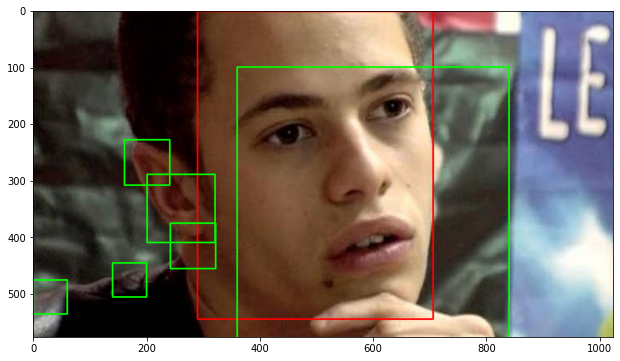

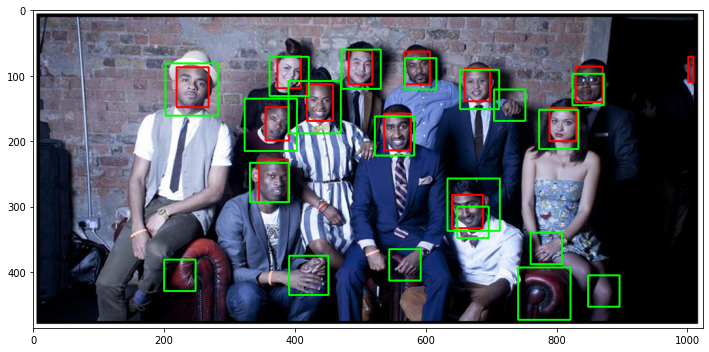

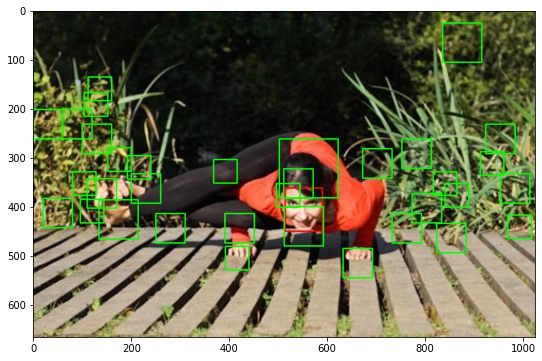

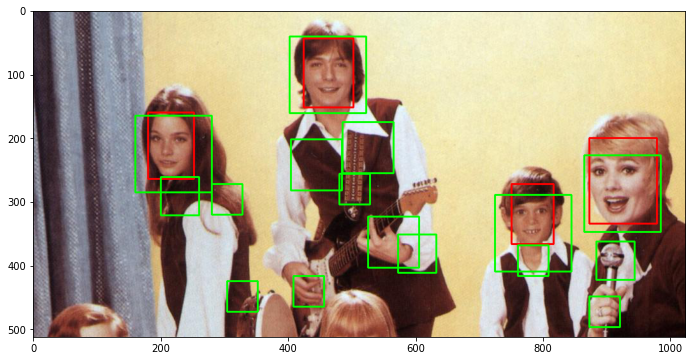

In [83]:
# Initialize the detector with the trained model and a threshold = 0.99
detector = FullyConvolutionalDetector(model_binaryConv, threshold=0.99)

for i in range(4):
    coordinates, probabilities = detector.detect_multi_scale(images[i])
    draw_boxes_with_gt(images[i], boxes[i], gt_boxes=coordinates)

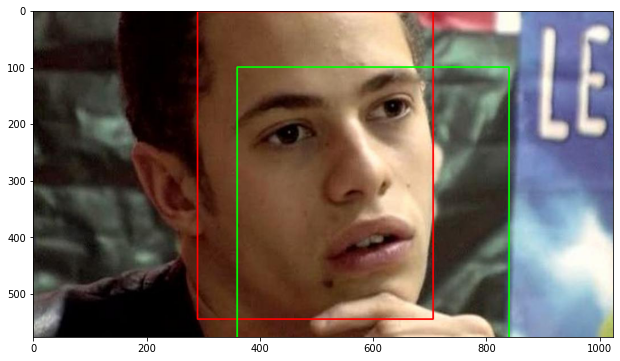

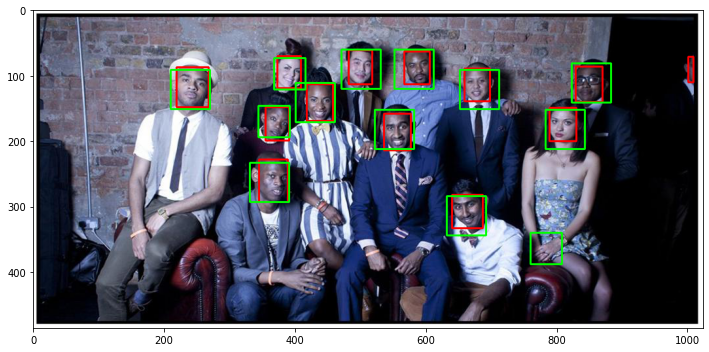

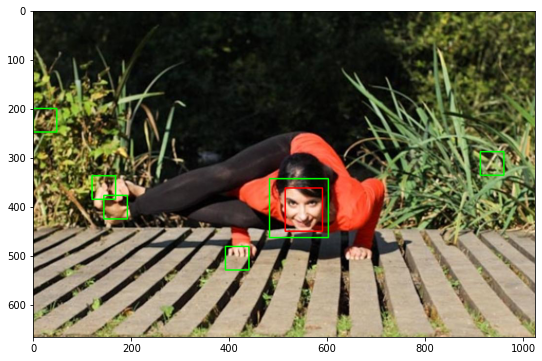

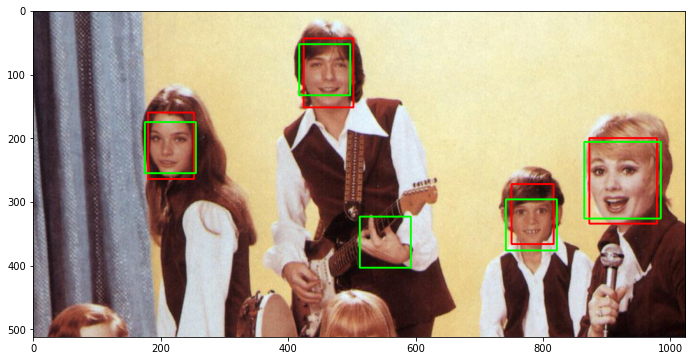

In [89]:
# Plot the detector with the trained model and a better performed threshold = 0.9997 and nms=False.
detector = FullyConvolutionalDetector(model_binaryConv, threshold=0.9997)

for i in range(4):
    coordinates, probabilities = detector.detect_multi_scale(images[i])
    draw_boxes_with_gt(images[i], boxes[i], gt_boxes=coordinates)

In [ ]:
# Plot the detector with the trained model and a better performed threshold = 0.9997 and nms=True.
detector = FullyConvolutionalDetector(model_binaryConv, threshold=0.9997)

for i in range(4):
    coordinates, probabilities = detector.detect_multi_scale(images[i], use_nms=nms)
    draw_boxes_with_gt(images[i], boxes[i], gt_boxes=coordinates)

# 3. Improve your model


In [92]:
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, ColorJitter
train_transforms = Compose([Resize((48,48)), ToTensor(), 
                            Normalize(mean=(0.5,0.5,0.5,), std=(0.5,0.5,0.5,)),
                            RandomHorizontalFlip(),]) 
valid_transforms = Compose([Resize((48,48)), ToTensor(), 
                            Normalize(mean=(0.5,0.5,0.5,), std=(0.5,0.5,0.5,)),]) 

batch_size = 128
train_dataset    = ImageFolder('./assignment2/train', transform=train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

valid_dataset    = ImageFolder('./assignment2/val', transform=valid_transforms)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [93]:
class BinaryConvModel_improved(nn.Module):
    def __init__(self, dropout_p=0.5):
        super(BinaryConvModel_improved, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(dropout_p),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Dropout(dropout_p),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(negative_slope=0.2),

            nn.Conv2d(in_channels=512, out_channels=2, kernel_size=1, stride=1)
        )

    def forward(self, input):
        output = self.conv_layers(input)
        return output

In [94]:
def train(model, train_dataloader, optimizer, loss_fn):
    losses = []
    predictions = 0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        output = output.view(output.size(0), output.size(1))
        optimizer.zero_grad()
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        predicted = output.argmax(1)
        predictions += (predicted==labels).sum().item()
    train_loss = sum(losses)/len(losses)
    train_accuracy = 100 * predictions / len(train_dataloader.dataset)
    return train_loss, train_accuracy

def evaluate(model, dataloader, loss_fn):
    losses = []
    predictions = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            output = output.view(output.size(0), output.size(1))
            loss = loss_fn(output, labels)

            losses.append(loss.item())
            predicted = output.argmax(1)
            predictions += (predicted==labels).sum().item()
    valid_loss = sum(losses)/len(losses)
    valid_accuracy = 100 * predictions / len(dataloader.dataset)
    return valid_loss, valid_accuracy

def fit_scheduler(train_dataloader, valid_dataloader, model, optimizer, loss_fn, n_epochs, scheduler=None):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    for epoch in range(n_epochs):
        model.train()
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
        model.eval()
        valid_loss, valid_accuracy = evaluate(model, valid_dataloader, loss_fn)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        if scheduler:
            scheduler.step()

        print('Epoch {:2}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, valid_loss: {:.4f}, valid_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                                             train_losses[-1], train_accuracies[-1],
                                                                                                                             valid_losses[-1], valid_accuracies[-1]))
    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [95]:
dropout_p = 0.2
model_improved = BinaryConvModel_improved(dropout_p=dropout_p).to(device)

learning_rate = 3e-3
optimizer = torch.optim.Adam(model_improved.parameters(), lr=learning_rate)
n_epochs = 10
loss_fn = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.1)
train_losses, valid_losses, train_accuracies, valid_accuracies = fit_scheduler(train_dataloader, valid_dataloader, 
                                                                               model_improved, optimizer, loss_fn, n_epochs, scheduler)

Epoch  1/10: train_loss: 0.2373, train_accuracy: 90.5574, valid_loss: 0.1929, valid_accuracy: 92.3100
Epoch  2/10: train_loss: 0.1700, train_accuracy: 93.4755, valid_loss: 0.2184, valid_accuracy: 91.7100
Epoch  3/10: train_loss: 0.1543, train_accuracy: 94.0754, valid_loss: 0.1399, valid_accuracy: 94.8500
Epoch  4/10: train_loss: 0.1420, train_accuracy: 94.6776, valid_loss: 0.1504, valid_accuracy: 94.0700
Epoch  5/10: train_loss: 0.1362, train_accuracy: 94.8355, valid_loss: 0.1305, valid_accuracy: 95.2000
Epoch  6/10: train_loss: 0.1102, train_accuracy: 95.8462, valid_loss: 0.1057, valid_accuracy: 96.0300
Epoch  7/10: train_loss: 0.1054, train_accuracy: 96.0813, valid_loss: 0.1049, valid_accuracy: 96.0300
Epoch  8/10: train_loss: 0.1013, train_accuracy: 96.1876, valid_loss: 0.1006, valid_accuracy: 96.1700
Epoch  9/10: train_loss: 0.0997, train_accuracy: 96.2100, valid_loss: 0.1018, valid_accuracy: 96.1600
Epoch 10/10: train_loss: 0.0986, train_accuracy: 96.3331, valid_loss: 0.0977, vali

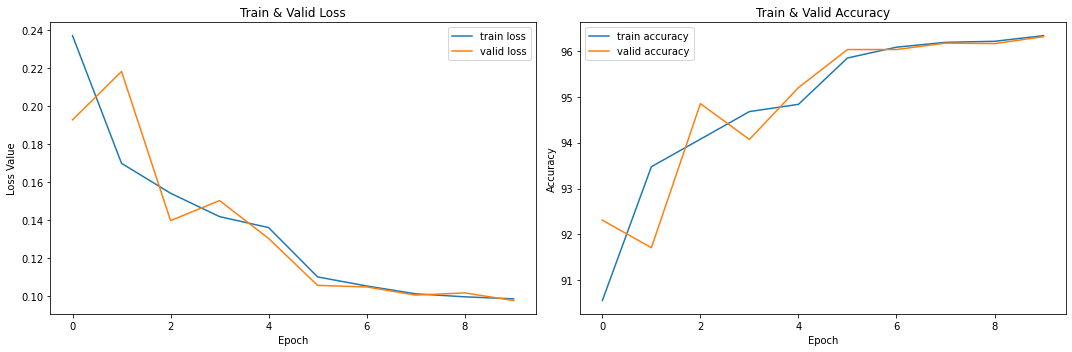

In [96]:
# Plot the improved result
plot(10, train_losses, train_accuracies, valid_losses, valid_accuracies)

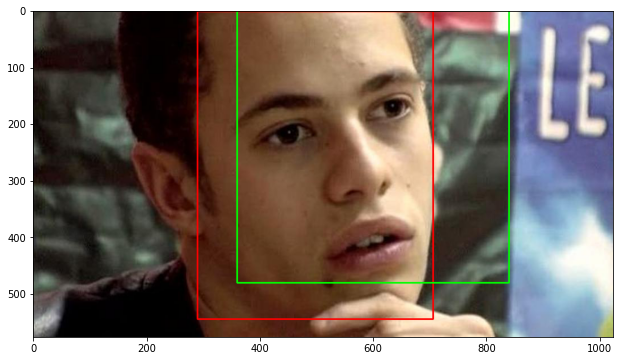

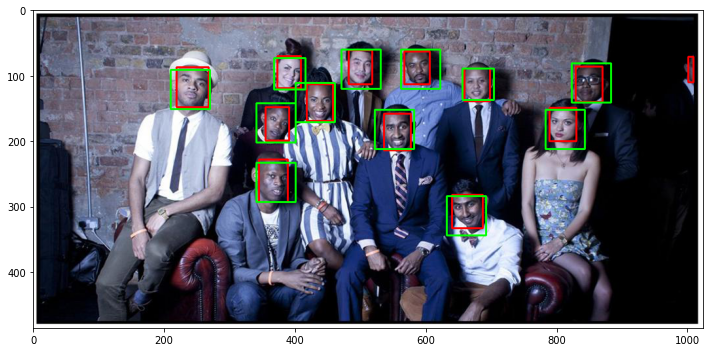

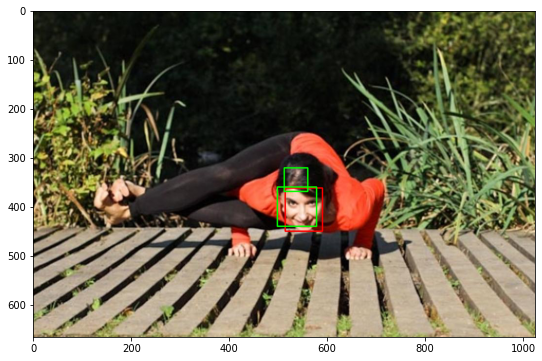

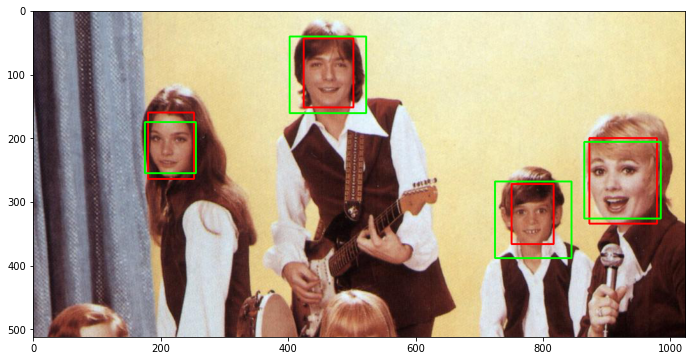

In [101]:
# Using my best model, plot the detection results
detector = FullyConvolutionalDetector(model_improved, threshold=0.9993)

for i in range(4):
    coordinates, probabilities = detector.detect_multi_scale(images[i])
    draw_boxes_with_gt(images[i], boxes[i], gt_boxes=coordinates)